In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [2]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def rbg_lab_preprocess(path, quality):
    temp_filename = 'temp_file_name.jpg'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    ela_cv = np.array(ela_image)
    ela_cv = cv2.cvtColor(ela_cv, cv2.COLOR_RGB2BGR)

    #RGB Detection
    gray_rgb = cv2.cvtColor(ela_cv, cv2.COLOR_BGR2GRAY)
    edges_rgb = cv2.Canny(gray_rgb, threshold1=50, threshold2=150)

    #LAB Edge Detection
    lab_image = cv2.cvtColor(ela_cv, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    edges_lab_l = cv2.Canny(l_channel, 50, 150)
    edges_lab_a = cv2.Canny(a_channel, 50, 150)
    edges_lab_b = cv2.Canny(b_channel, 50, 150)

    #Combine
    edges_lab = cv2.bitwise_or(edges_lab_l, edges_lab_a)
    edges_lab = cv2.bitwise_or(edges_lab, edges_lab_b)

    combined_edges = cv2.bitwise_or(edges_rgb, edges_lab)

    edges_colored = cv2.cvtColor(combined_edges, cv2.COLOR_GRAY2BGR)
    final_result = cv2.addWeighted(ela_cv, 0.9, edges_colored, 0.1, 0)

    final_result = cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB)
    final_image = Image.fromarray(final_result)

    return final_image


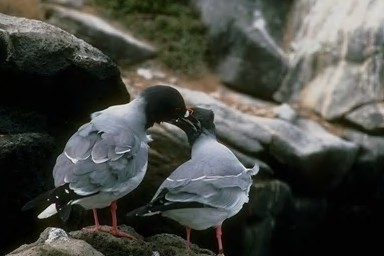

In [5]:
real_image_path = '/content/drive/MyDrive/casia-v2-ext/Au/Au_ani_00007.jpg'
Image.open(real_image_path)

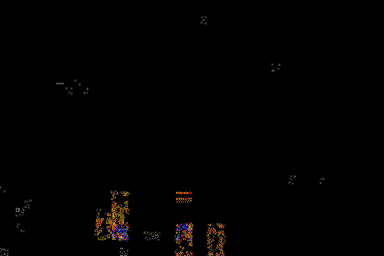

In [6]:
rbg_lab_preprocess(real_image_path, 90)

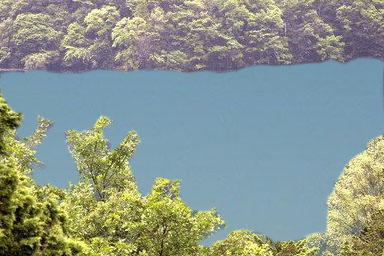

In [7]:
fake_image_path = '/content/drive/MyDrive/casia-v2-ext/Tp/Tp_D_CNN_M_N_nat00089_nat00062_10577.jpg'
Image.open(fake_image_path)

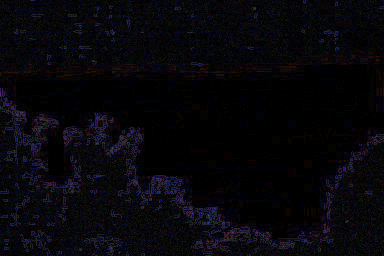

In [8]:

rbg_lab_preprocess(fake_image_path, 90)

In [9]:
image_size = (128, 128)

In [10]:
def focal_loss(gamma=2., alpha=.25):
    def loss_fn(y_true, y_pred):
        y_true = K.cast(y_true, tf.float32)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt + K.epsilon()))
    return loss_fn

In [11]:
def prepare_image(image_path):
    return np.array(rbg_lab_preprocess(image_path, 90).resize(image_size)).flatten() / 255.0

In [12]:
X = []
Y = []

In [15]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [13]:
import random
path = '/content/drive/MyDrive/casia-v2-ext/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [16]:
path = '/content/drive/MyDrive/casia-v2-ext/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [17]:
import tensorflow as tf
X = np.array(X)
Y = tf.keras.utils.to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [59]:
def encoder_block(inputs, num_filters):

	x = tf.keras.layers.Conv2D(num_filters,3,padding = 'valid')(inputs)
	x = tf.keras.layers.Activation('relu')(x)
	x = tf.keras.layers.Conv2D(num_filters,3,padding = 'valid')(x)
	x = tf.keras.layers.Activation('relu')(x)
	x = tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2)(x)

	return x

In [60]:
def decoder_block(inputs, skip_features, num_filters):

	x = tf.keras.layers.Conv2DTranspose(num_filters,(2, 2),strides = 2,padding = 'valid')(inputs)

	skip_features = tf.image.resize(skip_features,size = (x.shape[1],x.shape[2]))
	x = tf.keras.layers.Concatenate()([x, skip_features])
	x = tf.keras.layers.Conv2D(num_filters,3,padding = 'valid')(x)
	x = tf.keras.layers.Activation('relu')(x)
	x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'valid')(x)
	x = tf.keras.layers.Activation('relu')(x)

	return x

In [61]:
def build_unet_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [62]:
model = build_unet_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 120, 120, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,520,034 (112.61 MB)

 Trainable params: 29,520,034 (112.61 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
import tensorflow as tf


epochs = 30
batch_size = 32
init_lr = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr, decay=init_lr / epochs)

In [64]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'max')

In [66]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                )

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9925 - loss: 0.0223 - val_accuracy: 0.9316 - val_loss: 0.2447
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9941 - loss: 0.0276 - val_accuracy: 0.9304 - val_loss: 0.2829
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9951 - loss: 0.0162 - val_accuracy: 0.9316 - val_loss: 0.2954
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9967 - loss: 0.0143 - val_accuracy: 0.9256 - val_loss: 0.2934
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9937 - loss: 0.0201 - val_accuracy: 0.9304 - val_loss: 0.3179
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9954 - loss: 0.0198 - val_accuracy: 0.9172 - val_loss: 0.3542
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9946 - loss: 0.0182 - val_accuracy: 0.9196 - val_loss: 0.3214
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9947 - loss: 0.0195 - val_accu

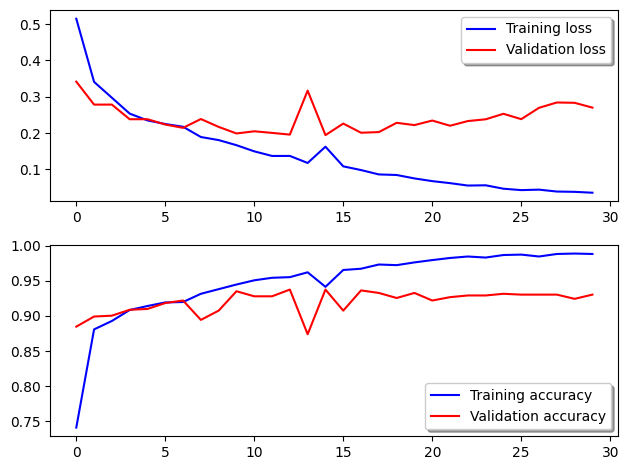

In [47]:
fig, ax = plt.subplots(2, 1)

# Loss Plot
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)

# Accuracy Plot
ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [32]:
predicted_classes = model.predict(X_val)
predicted_classes = np.argmax(predicted_classes, axis=1)
true_classes = np.argmax(Y_val, axis=1)

test_accuracy = accuracy_score(true_classes, predicted_classes)
print("Test Accuracy:", test_accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test Accuracy: 0.9303721488595438


In [33]:
class_labels = ['Fake', 'Real']
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

        Fake       0.92      0.94      0.93       407
        Real       0.94      0.92      0.93       426

    accuracy                           0.93       833
   macro avg       0.93      0.93      0.93       833
weighted avg       0.93      0.93      0.93       833



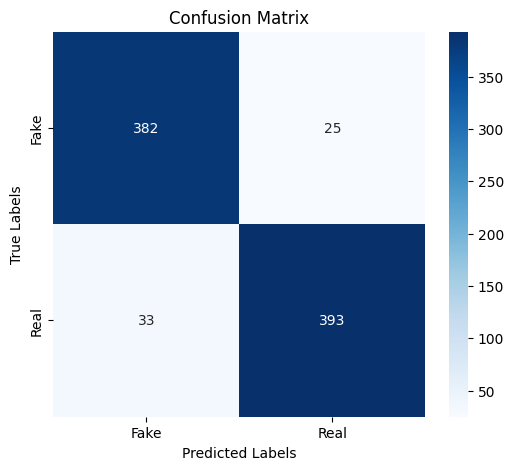

In [34]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [35]:
model.save('image_forgery_detection_casia2.h5')

In [36]:
from PIL import Image, ImageChops, ImageEnhance

In [37]:
image_size = (128, 128)
def prepare_image(image_path):
    return np.array(rbg_lab_preprocess(image_path, 90).resize(image_size)).flatten() / 255.0

In [38]:
def rbg_lab_preprocessold(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [39]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt


model = load_model('/content/drive/MyDrive/image_forgery_detection_casia2.h5')

def prepare_image_for_prediction(image_path):
    image_array = prepare_image(image_path)
    image_array = image_array.reshape(1, 128, 128, 3)
    return image_array

def predict_image(image_path):
    image = prepare_image_for_prediction(image_path)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)[0]

    label = "Real" if predicted_class == 1 else "Fake"
    confidence = prediction[0][predicted_class] * 100

    original_image = Image.open(image_path).resize((256, 256))
    ela_image = rbg_lab_preprocess(image_path, 90).resize((256, 256))

    # plt.figure(figsize=(8, 8))
    # plt.imshow(original_image)
    # plt.title("Original Image", fontsize=16)
    # plt.axis('off')
    # plt.show()

    # plt.figure(figsize=(8, 8))
    # plt.imshow(ela_image)
    # plt.title(f"RGB-LAB - {label} ({confidence:.2f}%)", fontsize=16)
    # plt.axis('off')
    # plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(ela_image)
    axes[1].set_title(f"RGB-LAB - {label} ({confidence:.2f}%)")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Prediction: {label} ({confidence:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


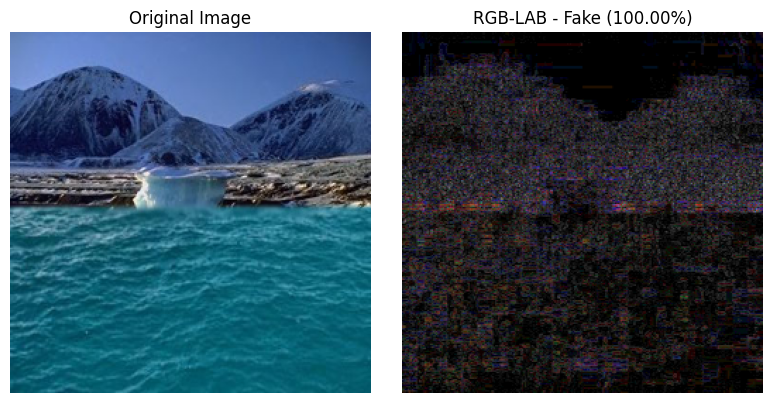

Prediction: Fake (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


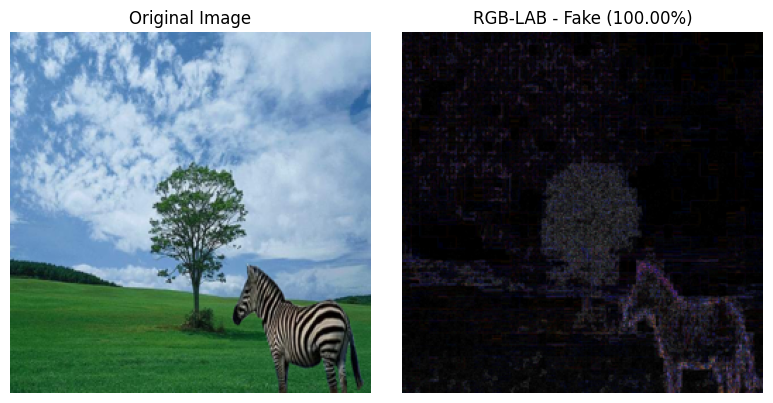

Prediction: Fake (100.00%)


In [68]:
# predict_image("/content/drive/MyDrive/casia-v2-ext/Au/Au_ani_00075.jpg")
predict_image("/content/drive/MyDrive/casia-v2-ext/Tp/Tp_D_CNN_M_B_nat00056_nat00099_11105.jpg")
predict_image("/content/drive/MyDrive/casia-v2-ext/Tp/Tp_D_CRN_M_N_nat10156_ani00001_12021.jpg")